# Week 12: Colab Experiment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# I. Introduction
In this exercise, we learn an autoencoder to reconstruct the MNIST images and extract the representations.

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random


In [4]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 110447097.20it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40910399.81it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 172582322.18it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 3116905.88it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



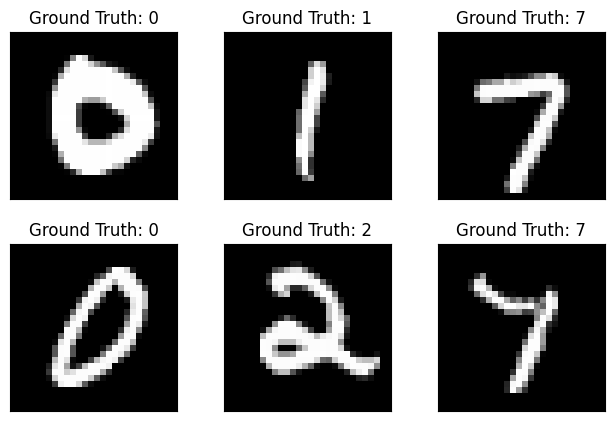

In [5]:

# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# II. Methods
The encoder at least 3 hidden layers, each with 128, 64, and 2 hidden units respectively. The decoder also has at least 3 layers with the same number of hidden units in reversed order. We train the autoencoder with 10 epochs, learning_rate = 2e-3, to minimize the MSE.

In [43]:
# Finish the Model
class LAutoencoder(nn.Module):
# TODO
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
            )
        self.decoder = nn.Sequential(
            # reversed order
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, 784)
            )
# TODO
    def forward(self, x):
        #encoded
        latent = self.encoder(x)
        #decoded
        x = self.decoder(latent)
        return x,latent

# Training steps

In [44]:
num_epochs = 10
learning_rate = 2e-3

model = LAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate)

# TODO : Fininsh the training steps
for epoch in range(num_epochs):
    for data in train_loader:
      # get the image input
      img = data[0]
      # flattened the image so that it can be processed by the linear layer
      img = img.view(img.size(0), 784)
      # get the predicted output
      output, latent = model(img)
      # compute the loss
      loss = criterion(output, img)

      # starting gradients set to zero
      optimizer.zero_grad()
      # do backpropagration
      loss.backward()
      # update the parameters
      optimizer.step()


    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.data.item()}')


epoch [1/10], loss:0.40816813707351685
epoch [2/10], loss:0.41725295782089233
epoch [3/10], loss:0.4826689064502716
epoch [4/10], loss:0.3888159692287445
epoch [5/10], loss:0.4007006585597992
epoch [6/10], loss:0.4002104699611664
epoch [7/10], loss:0.4410499334335327
epoch [8/10], loss:0.4546891748905182
epoch [9/10], loss:0.4580594599246979
epoch [10/10], loss:0.43151599168777466


## III. Results

We train the autoencoder model and apply it to the test set. There is no validation set here, we simply take the model at the end of the training procedure. The scatter plot of the embeddings are shown below, with each digit colored differently.

In [46]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def scatter_plot(data_loader):

  d = {0: 'red', 1: "green", 2: "blue", 3: "maroon", 4: "yellow",
      5: "pink", 6: "brown", 7: "black", 8: "teal", 9: "aqua"}

  colors = []
  latent_variables = []
  labels = []

  for data in data_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    model.cpu()
    _,latent = model(img)
    latent_variables.append(latent)
    labels.append(label)


  latent_variables = torch.cat(latent_variables, dim=0)
  labels = torch.cat(labels, dim=0)


  df = pd.DataFrame(data = latent_variables.detach().numpy(), columns = ['Latent feature 1', 'Latent feature 2'])
  df['label'] = labels.numpy()

  fig = plt.figure(dpi=200)
  sns.scatterplot(data=df, x="Latent feature 1", y="Latent feature 2", hue="label", palette="deep")
  plt.show()

The test set:


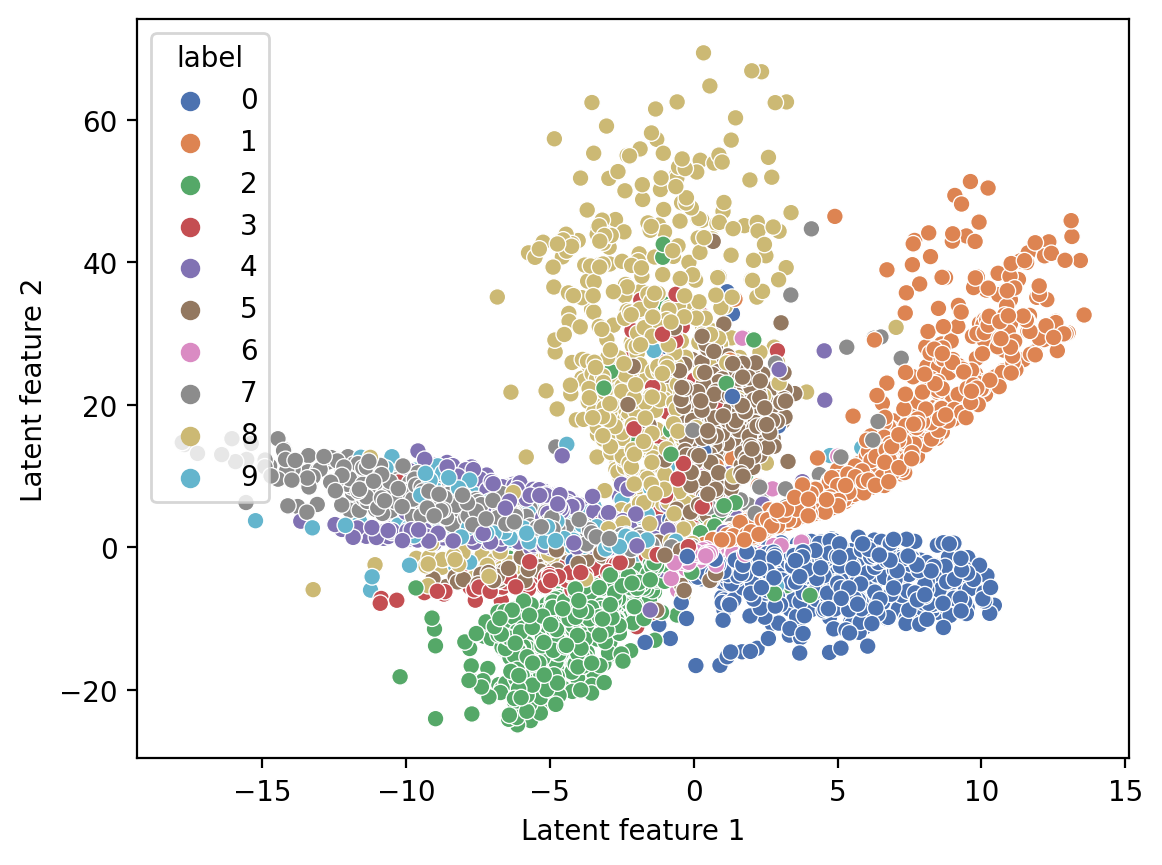

In [47]:
print("The test set:")
scatter_plot(test_loader)

# IV. Conclusion and Discussion



- I tried making a very deep network with alternating layers consisting of linear and ReLU (the encoder has 13 layers), and it result in the loss to be higher than 0.5. After reducing the amount of layers, the loss is now better, with the loss being around 0.4. Perhaps, the data is not complex enough to require a very deep network.

- I made sure to use ReLU between the linear layers to introduce non-linearities, and this made the network to understand the patterns behind the dataset better. (I tested running without using ReLU, and the loss is always > 0.5 and even > 0.6)